# Comparison between Deterministic and Stochastic evolutionary models.

- 2 deterministic models (individualistic ou communautary) both with Integer and with percentages :  EvolDeterInt EvolDeterReal (ex M2)
- 2 stochastic models where we choose 2 individuals randomly and where we increase population depending of the scores : EvolEncounter (ex M3)
- 2 stochastic models based on Moran process, where a fitness is computed for each individual, and where we use this fitness as a probability to choose one individual on which we increase or decrease by 1, the population: EvolMoran (ex M4)
- 2 stochastic models based on Fermi process where we choose 2 individuals based on their fitness, then they make a meeting, and we increase or decrease the population depending of the meeting result:"EvolFermi" (M5)

We use two notions of fitness: one individualistic and one communitarian
- each individual meets all the individuals of the soup, except himself (`ind`, classical model)
- each individual meets all the individuals of the soup, except those of his own community (`com`, diag=0)

Deterministic models can be used both with integer or real numbers (percentages).
With stochastic models, there is no more computation with the reals, so we only compute with integers.

We will see that individualistic models will give roughly the same result, same for the community models


In [1]:
%run ../src/ipd.py
%run ../src/strategies.py
%run ../src/evolutions.py

import sys
import pandas as pd
import time
import itertools as it
from scipy.cluster.hierarchy import dendrogram, linkage


# real formatting in numpy and pandas
pd.set_option('display.float_format', lambda x: '%.3f' % x)
np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})


bag20 = getClassicals()[0:20]
bag4 = [Periodic('CCD','per_ccd'), Periodic('DDC','per_ddc'), Prober(),Mistrust()]
bag5 = [Periodic('CCD','per_ccd'), Periodic('DDC','per_ddc'), Prober(), SoftMajority(),HardMajority()]
bag6 = [Prober(), Periodic('C','allC'), Mistrust(), Periodic('D','allD'), Tft(), Gradual()]
bag8 = [Periodic('D','allD'), Periodic('CCD','CCD'), Periodic('DDC','DDC'), HardMajority(), Mistrust(), Tft(), Gradual(), Spiteful()]  # 3 Nice
bag11= getClassicals()[0:9]+[Prober(),Gradual()]
bagDyson=[Proba('C',1.0,0.3,0.7,0.0) , Proba('C',0.9,0.7,0.2,0.1), Proba('C',0.9,0.5,0.5,0.3), Proba('C',0.8,0.1,0.6,0.0), Proba('C',0.85,0.075,0.7,0)] 

# Just an example with bag6
bag = bag6
m1 = m1 = Tournament(g,bag,length=100)
m1.run()
m1.matrix


,prober,gradual,tft,mistrust,allC,allD,Total
prober,104,299,299,295,496,98,1591
gradual,299,300,300,296,300,89,1584
tft,299,300,300,250,300,99,1548
mistrust,300,301,250,100,302,100,1353
allC,6,300,300,297,300,0,1203
allD,108,144,104,100,500,100,1056


## Simple examples showing that ZDs are not good with bag>2

In [2]:
# An extorquer plays badly against himself, it loses points
# Here we illustrate this fact with 2 Spiteful against one extorquer, and angains one equalizer

extorq = Proba('C', 17.0/20, 3.0/40, 7.0/10, 0.0, 'extorq')
equaliz = Proba('C', 9.0/10, 1.0/2, 1.0/2, 3.0/10, 'equaliz')

ranc1 = Spiteful()
ranc2 =  Mem(1,1,"cCDDD","mem11_cCDDD-spite")
t = Tournament(g, [ranc1,ranc2, equaliz, extorq], length=1000)
t.run()
print(t.matrix)


                   spiteful  mem11_cCDDD-spite  equaliz  extorq  Total
spiteful               3000               3000     2585    1003   9588
mem11_cCDDD-spite      3000               3000     2475    1007   9482
equaliz                 640                670     2515    1993   5818
extorq                 1008               1012     2503    1022   5545


## According to the methods, the rankings are different

The following code allows to find bags of different size from `getClassicals` , showing that the tournament ranking is different (at least the first 2) from the ecological competition

In [3]:
for nb in range(4, 8):
    for i in range(1, 100):
        # nb = 3
        # np.random.randint(3,6)
        bag =  random.sample(getClassicals()[0:17], nb)
        t = Tournament(g, bag, length=100)
        t.run()
        tv = TournamentVictory(t)
        tv.run()
        c1=Classic('ind',t) 
        c1.run()
        c2=Classic('com',t) 
        c2.run()
        m1=EvolDeterInt('ind', t , 100 , 1000)
        m1.run()
        m2=EvolDeterInt('com', t , 100 , 1000)
        m2.run()
        # Pour avoir le tri des resultats. Sinon avec Ecological ça serait m1.history.columns[0]
        df=m1.getRanking().sort_values(by='rank_Det_ind',ascending=True)
        df.sort_values(by='rank_Det_ind',ascending=True)
        # We just test the difference with the two firt positions of the ranking
        if t.matrix.index[0] != df.index[0] and t.matrix.index[0] != df.index[1] and t.matrix.index[1] != df.index[0] and t.matrix.index[1] != df.index[1]:
            print('Bag=', [s.name for s in bag])

Bag= ['mistrust', 'allD', 'per_CCD', 'per_CD', 'hardmajo']
Bag= ['per_CCD', 'prober', 'pavlov', 'hardmajo', 'allC']
Bag= ['per_CD', 'tf2t', 'tft', 'per_DDC', 'allC', 'allD']
Bag= ['pavlov', 'per_CD', 'per_DDC', 'allC', 'per_CCD', 'softmajo']
Bag= ['mistrust', 'per_CCD', 'allC', 'softmajo', 'hardtft', 'per_CD', 'tf2t']
Bag= ['tft', 'pavlov', 'slowtft', 'allC', 'per_CD', 'per_CCD', 'hardmajo']


In [4]:
# Verification of one of the previous bag
bag=[Periodic('CCD','per_CCD'), Gradual(), SoftMajority(), Prober(), Periodic('C','allC')]
t = Tournament(g, bag, length=10)
t.run()
e = Ecological(t, pop=100)
# or also   e = EvolDeterInt('ind',t,100,1000)
e.run()
print(t.matrix['Total'])
e.historic.iloc[-1:]

per_CCD     147
prober      147
gradual     146
softmajo    140
allC        117
Name: Total, dtype: int64


,gradual,softmajo,per_CCD,prober,allC
69,443.000,56.000,0.000,0.000,0.000


## Ranking matrix fro a given bag

The method `resultMatrix` allows to have a synthesis table of the scores and ranks of each method. 
In its simplest form, it simply takes a bag as a parameter, automatically runs all the methods and provides a summary in 2 DataFrames: the first with the results, the second with the ranks.

We can have fun to see what it gives with the following bags (found by the previous method)

`bag = [Gradual(), Tft(), Prober(), Mistrust(), Periodic('C','AllC'),Periodic('D','allD')]` called previously bag6

`bag = [Periodic('CCD','per_CCD'), Gradual(), SoftMajority(), Prober(), Periodic('C','allC')]` called previously bag5

These tables illustrate very clearly the difference in ranking that can be obtained according to the methods.

In [5]:
bag=bag6
res,rank = resultMatrix(bag,methods='D') #, normalized=False)
print(res.sort_values(by="VicT"))
rank.sort_values(by="rank_VicT")

D
          VicT  ClaT_ind  ClaT_com  Det_ind  Det_com
allC     0.083     0.144     0.127    0.000    0.003
gradual  0.111     0.190     0.180    0.599    0.266
prober   0.139     0.191     0.209    0.000    0.268
tft      0.139     0.186     0.175    0.401    0.231
mistrust 0.250     0.162     0.176    0.000    0.232
allD     0.278     0.127     0.134    0.000    0.000


,rank_VicT,rank_ClaT_ind,rank_ClaT_com,rank_Det_ind,rank_Det_com
allD,1.000,6.000,5.000,4.500,6.000
mistrust,2.000,4.000,3.000,4.500,3.000
prober,3.500,1.000,1.000,4.500,1.000
tft,3.500,3.000,4.000,2.000,4.000
gradual,5.000,2.000,2.000,1.000,2.000
allC,6.000,5.000,6.000,4.500,5.000


## Distance Matrix
With the obtained results it is then possible to compute a 'distance' between the methods. The distance matrix is computed on normalized results. Of course the distance of a method with itself being 0, the diagonal of this matrix is 0.
This distance can be computed in two ways, either with a Euclidean distance, or with the Spearman method.
We will prefer the Euclidean distance.

In [6]:
# Compute an euclidian distance matrix 
from math import sqrt
def distance(df):
    x = pd.DataFrame(columns=df.columns, index=df.columns)
    for i in (range(df.shape[1])):
        for j in (range(df.shape[1])):
            x.iloc[i,j]= sqrt(sum((df.iloc[:,i]-df.iloc[:,j])**2))
    return x

# Make sure that the res matrix is normalized!
dist = distance(res)
dist

,VicT,ClaT_ind,ClaT_com,Det_ind,Det_com
VicT,0.000,0.213,0.197,0.688,0.364
ClaT_ind,0.213,0.000,0.033,0.560,0.233
ClaT_com,0.197,0.033,0.000,0.579,0.224
Det_ind,0.688,0.560,0.579,0.000,0.515
Det_com,0.364,0.233,0.224,0.515,0.000


<Axes: >

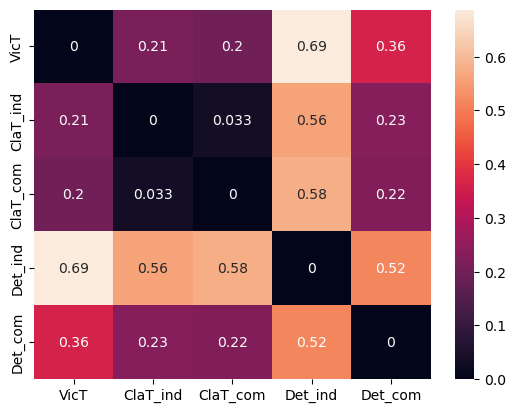

In [7]:
import seaborn as sns
dist = dist.astype(float)  #  Visiblement il ne considere pas les données comme numériques
sns.heatmap(dist, annot = True)

### We can also compute this distance with the Spearman method

In [8]:
corr = rank.corr(method='spearman')
dist=1-corr
dist

,rank_VicT,rank_ClaT_ind,rank_ClaT_com,rank_Det_ind,rank_Det_com
rank_VicT,0.000,1.319,0.942,1.360,1.232
rank_ClaT_ind,1.319,0.000,0.114,0.561,0.057
rank_ClaT_com,0.942,0.114,0.000,0.730,0.057
rank_Det_ind,1.360,0.561,0.730,0.000,0.730
rank_Det_com,1.232,0.057,0.057,0.730,0.000


## Dendrogram
From a distance matrix between the methods, it is then possible to display a dendrogram illustrating the 'proximity' of the different methods.

/var/folders/8l/471vznc93g38vw6qr2svj6f80000gn/T/ipykernel_21097/828375071.py:4: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z = linkage(dist,method='average',metric='euclidean')


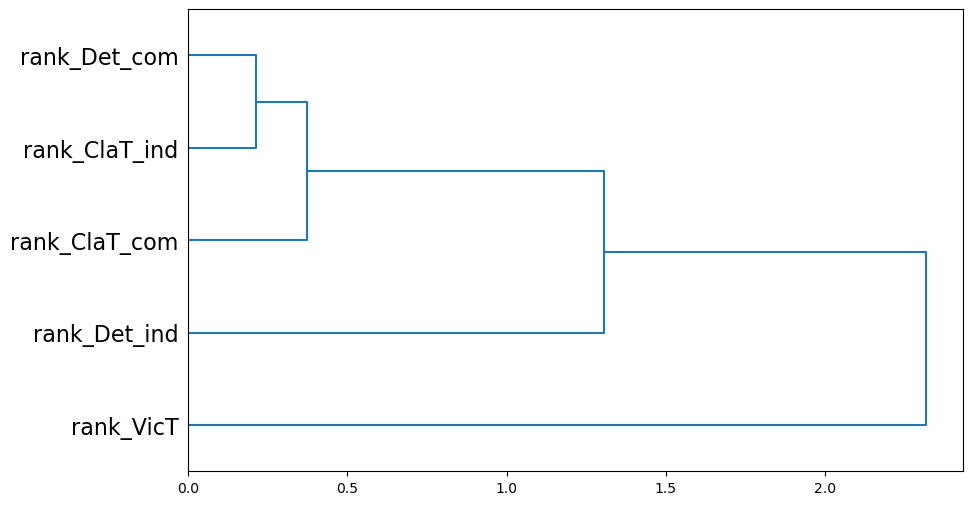

In [9]:
plt.figure(figsize=(10,6))

# générer la matrice des liens
Z = linkage(dist,method='average',metric='euclidean')
#affichage du dendrogramme
dendrogram(Z,labels=dist.index,orientation='right',color_threshold=0, leaf_font_size=16)
plt.savefig("dendo_11meth_bag20_RANKS.png", dpi=500)
plt.show()


## Cumulative distance matrix

Computing a distance matrix (and thus a dendogram) on a single bag is probably not very reliable. In order to stabilize the result it is interesting to cumulate the distance matrices of several bags. This is the purpose of the `cumulativeDistanceMatrix` method.

In [10]:
bag=bag6
dist,rank = cumulativeDistanceMatrix([bag5,bag6,bag11,bag20,getMem11()],methods="D")
rank

D
-------------  0  -----------------
D
-- result normé : --
           VicT  ClaT_ind  ClaT_com  Det_ind  Det_com
per_ccd  0.200     0.246     0.243    0.468    0.359
per_ddc  0.200     0.149     0.143    0.303    0.052
prober   0.160     0.197     0.212    0.096    0.261
softmajo 0.200     0.226     0.206    0.133    0.185
hardmajo 0.240     0.183     0.196    0.000    0.143
-- dist result :--
           VicT ClaT_ind ClaT_com Det_ind Det_com
VicT     0.000    0.100    0.099   0.385   0.259
ClaT_ind 0.100    0.000    0.030   0.354   0.173
ClaT_com 0.099    0.030    0.000   0.366   0.166
Det_ind  0.385    0.354    0.366   0.000   0.353
Det_com  0.259    0.173    0.166   0.353   0.000
-- rank : --
           rank_VicT  rank_ClaT_ind  rank_ClaT_com  rank_Det_ind  rank_Det_com
per_ccd       3.000          1.000          1.000         1.000         1.000
per_ddc       3.000          5.000          5.000         2.000         5.000
prober        5.000          3.000          2.000         

,rank_VicT,rank_ClaT_ind,rank_ClaT_com,rank_Det_ind,rank_Det_com
rank_VicT,0.000,5.569,5.373,6.391,6.812
rank_ClaT_ind,5.569,0.000,0.273,2.245,1.354
rank_ClaT_com,5.373,0.273,0.000,2.648,1.167
rank_Det_ind,6.391,2.245,2.648,0.000,1.833
rank_Det_com,6.812,1.354,1.167,1.833,0.000


# Stochastic methods
We study now with the same kind of analysis, 6 stochastic methods :
- `EvolEncounter` where we choose 2 individuals randomly and where we increase population depending of the scores
- `EvolMoran` where a fitness is computed for each individual, and where we use this fitness as a probability to choose one individual on which we increase or decrease by 1, the population
- `EvolFermi` where we choose 2 individuals based on their fitness, then they make a meeting, and we increase or decrease the population depending of the meeting result

Each of them can be close to an individualistic model or a communautary model. Usually 200.000 steps at worst are needed.

**They all take time !! ... several minutes**

[329382 325951 283377 256009   5281      0] 	->  prober
figure sauvée : 6str_EvolEncounter_com_1711575417997.png


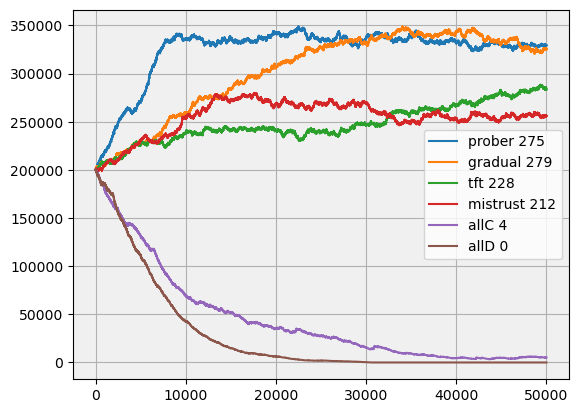

In [11]:
bag=bag6
t = Tournament(g,bag,100)
t.run()
m3=EvolEncounter('com', t, 200000 , 50000)
m3.run()
m3.drawPlot()

# Back to `resultMatrix()`
La methode resultMatrix peut bien évidemment prendre en compte les méthodes précédentes. Elle permet plusieurs paramètres :
- `methods`qui peut prendre comme valeurs (A)ll, (D)eterministic, (S)tochastics, (T)tournaments, (E)volutionaries, (C)ommunautary evol,  (I)ndividualistic evol  (`D` par défaut)
- `repeat` qui permet de répéter plusieurs fois une méthode stochastique et en cumuler les résultats (`5` par défaut)
- `normalized` qui permet de normaliser le résultat ou pas (`True` par defaut)

On peut donc calculer le résultat synthétique des 11 méthodes possibles par
`res,rank = resultMatrix(bag6,methods='All')`

**They take 11 times more time than juste one stochastic method, thus more than 30mn with 'All' !!**


In [12]:
res,rank = resultMatrix(bag6,methods='D')
print(rank)
res

D
          rank_VicT  rank_ClaT_ind  rank_ClaT_com  rank_Det_ind  rank_Det_com
prober        3.500          1.000          1.000         4.500         1.000
allC          6.000          5.000          6.000         4.500         5.000
mistrust      2.000          4.000          3.000         4.500         3.000
allD          1.000          6.000          5.000         4.500         6.000
tft           3.500          3.000          4.000         2.000         4.000
gradual       5.000          2.000          2.000         1.000         2.000


,VicT,ClaT_ind,ClaT_com,Det_ind,Det_com
prober,0.139,0.191,0.209,0.000,0.268
allC,0.083,0.144,0.127,0.000,0.003
mistrust,0.250,0.162,0.176,0.000,0.232
allD,0.278,0.127,0.134,0.000,0.000
tft,0.139,0.186,0.175,0.401,0.231
gradual,0.111,0.190,0.180,0.599,0.266


## Back to `cumulativeDistanceMatrix()`

As for `resultmatrix`, the possible methods can be passed as parameters.

**Take care : 2H30 min to execute this method with (A)ll !!**


In [13]:
# Test rapide
dist,rank = cumulativeDistanceMatrix([bag5,bag6], methods="D")
# Test Complet (plus de 3h00 de calcul)
# dist,rank = cumulativeDistanceMatrix([bag5,bag6,bag11,bag20,getMem11(),bag20+bagDyson],methods="A")
# ou
print(dist)
rank

D
-------------  0  -----------------
D
-- result normé : --
           VicT  ClaT_ind  ClaT_com  Det_ind  Det_com
per_ccd  0.200     0.246     0.243    0.468    0.359
per_ddc  0.200     0.149     0.143    0.303    0.052
prober   0.160     0.197     0.212    0.096    0.261
softmajo 0.200     0.226     0.206    0.133    0.185
hardmajo 0.240     0.183     0.196    0.000    0.143
-- dist result :--
           VicT ClaT_ind ClaT_com Det_ind Det_com
VicT     0.000    0.100    0.099   0.385   0.259
ClaT_ind 0.100    0.000    0.030   0.354   0.173
ClaT_com 0.099    0.030    0.000   0.366   0.166
Det_ind  0.385    0.354    0.366   0.000   0.353
Det_com  0.259    0.173    0.166   0.353   0.000
-- rank : --
           rank_VicT  rank_ClaT_ind  rank_ClaT_com  rank_Det_ind  rank_Det_com
per_ccd       3.000          1.000          1.000         1.000         1.000
per_ddc       3.000          5.000          5.000         2.000         5.000
prober        5.000          3.000          2.000         

,rank_VicT,rank_ClaT_ind,rank_ClaT_com,rank_Det_ind,rank_Det_com
rank_VicT,0.000,2.542,2.389,2.584,2.679
rank_ClaT_ind,2.542,0.000,0.214,1.161,0.157
rank_ClaT_com,2.389,0.214,0.000,1.430,0.057
rank_Det_ind,2.584,1.161,1.430,0.000,1.430
rank_Det_com,2.679,0.157,0.057,1.430,0.000


/var/folders/8l/471vznc93g38vw6qr2svj6f80000gn/T/ipykernel_21097/2653251976.py:2: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z = linkage(dist,method='average',metric='euclidean')


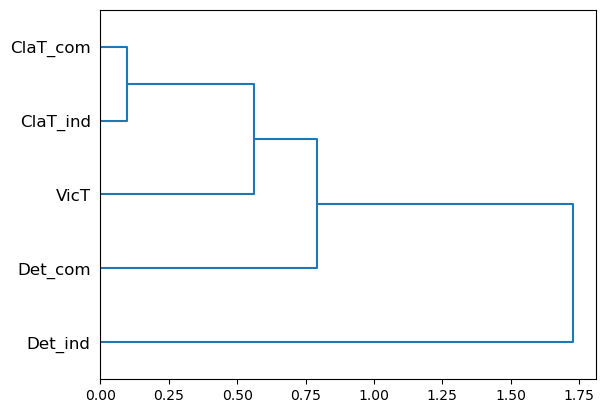

/var/folders/8l/471vznc93g38vw6qr2svj6f80000gn/T/ipykernel_21097/2653251976.py:9: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z = linkage(rank,method='average',metric='euclidean')


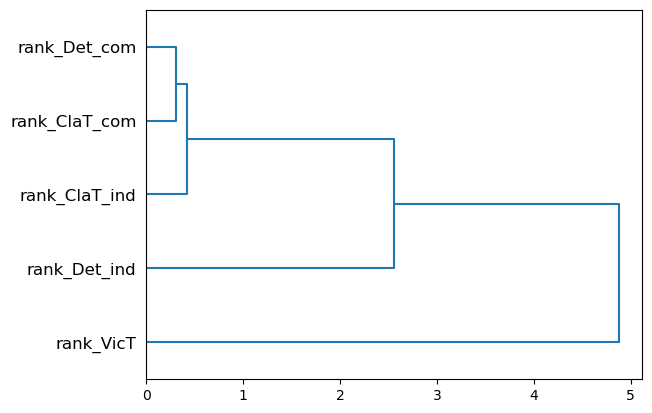

In [14]:
# Dendrogram on distances
Z = linkage(dist,method='average',metric='euclidean')
dendrogram(Z,labels=dist.index,orientation='right',color_threshold=0)
plt.savefig("dendo_5meth_6bags_Results.png", dpi=500)
plt.show()
plt.close()

# Dendrogram on ranks
Z = linkage(rank,method='average',metric='euclidean')
dendrogram(Z,labels=rank.index,orientation='right',color_threshold=0)
plt.savefig("dendo_5meth_6bags_Ranks.png", dpi=500)
plt.show()
plt.close()


## Barycentric representation of several trajectories

18  trajectories
[57004 57387 50201 50408     0     0] 	->  gradual
[55660 59320 47391 52629     0     0] 	->  gradual
[51582 59540 48970 54908     0     0] 	->  gradual
[63957 62453 34058 54532     0     0] 	->  prober
[54417 60063 51168 49352     0     0] 	->  gradual
[53587 58826 53798 48789     0     0] 	->  gradual
[59517 66520 46988 51975     0     0] 	->  gradual
[61516 60771 52990 49723     0     0] 	->  prober
[60939 63161 45901 54999     0     0] 	->  gradual
[62449 66465 47563 48523     0     0] 	->  gradual
[63695 57262 57715 46328     0     0] 	->  prober
[68995 60891 44542 50572     0     0] 	->  prober
[64611 70387 56892 58110     0     0] 	->  gradual
[67416 70008 57717 54859     0     0] 	->  gradual
[70925 64166 56129 58780     0     0] 	->  prober
[72683 74703 47221 55393     0     0] 	->  gradual
[72727 66101 56567 54605     0     0] 	->  prober
[68688 66933 51266 63113     0     0] 	->  prober
prober     68688.000
gradual    66933.000
tft        51266.000
mistrust 

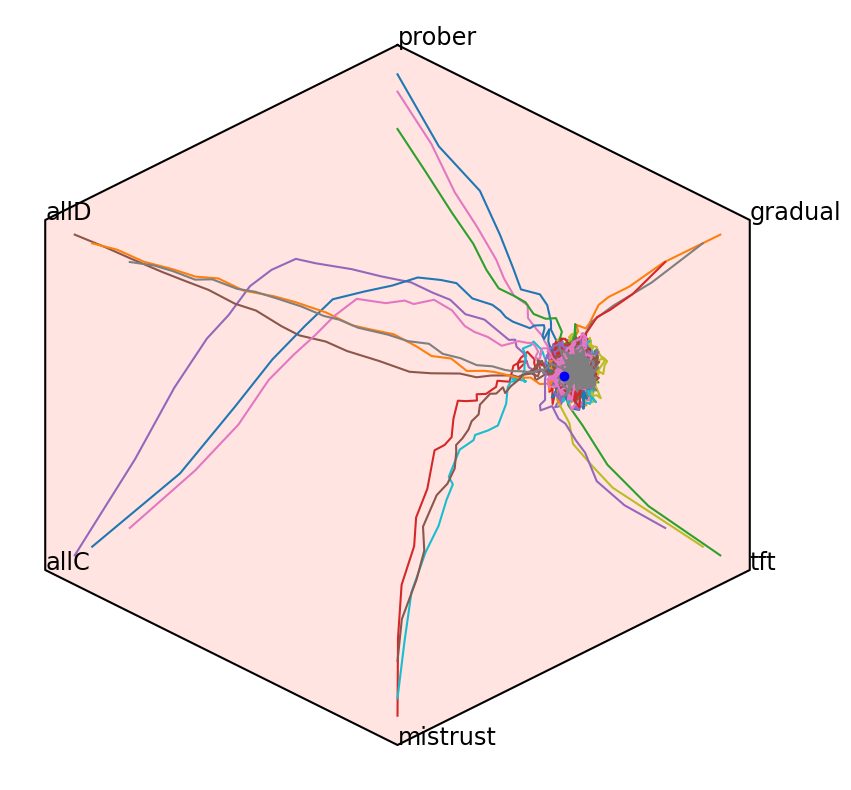

In [15]:
# 1vsTous : les dessins classiques des articles JFSMA 2021, 2024 et EVOL COMPUT
bag=bag6
pops=[] 
starts=[3000,5000,10000]
for n in starts :
    for i in range(len(bag)) :
        p1=[n]*len(bag)
        p1[i]=200000
        pops.append(p1)
print(len(pops),' trajectories')
draw_polygon(bag, 'Encounter', 'com', pops, 'bag6_polygon_Enc_com_1vsTous'+str(starts))


15  trajectoires
prober     544.000
gradual    543.000
tft        470.000
mistrust   476.000
allC         5.000
allD         0.000
abs          0.428
ord          0.050
Name: 18, dtype: float64
figure sauvée : bag6_polygon_DeterInt_com_2[1000]vsTous[10]


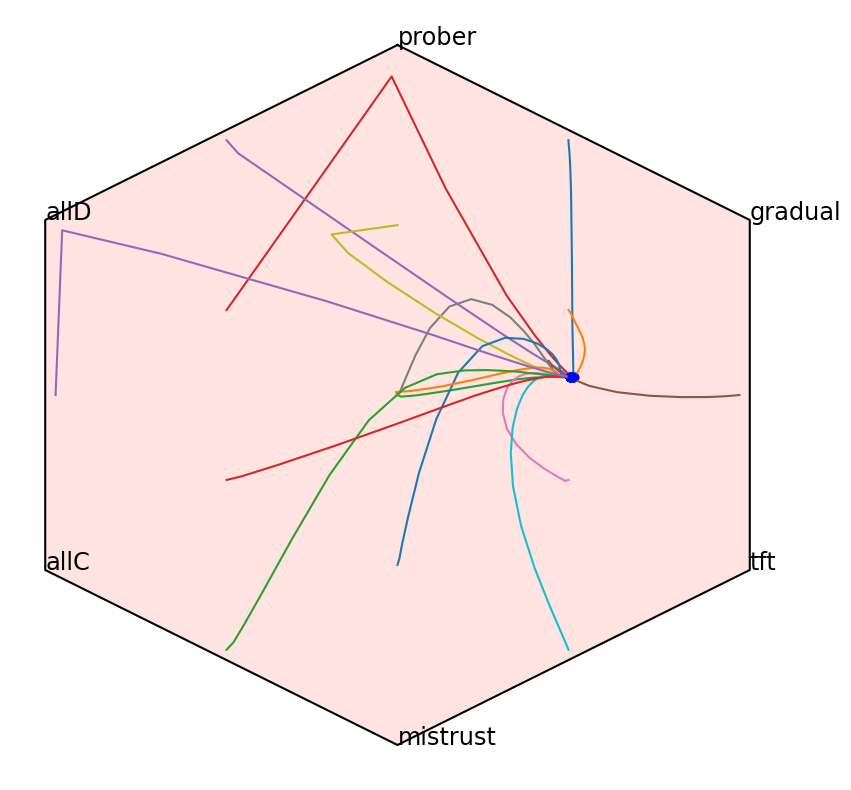

In [16]:
# 2 vs Tous
bag=bag6
pops=[] 
starts=[10]
for n in starts :
    for i in range(len(bag)) :
        for j in range(i+1,len(bag)) :
            p=[n]*len(bag)
            p[i]=1000
            p[j]=1000
            pops.append(p)
print(len(pops),' trajectoires')
draw_polygon(bag, 'DeterInt', 'com', pops, 'bag6_polygon_DeterInt_com_2[1000]vsTous'+str(starts))

729  trajectoires
6561  trajectoires
gradual    290.000
tft        196.000
spiteful   112.000
CCD          0.000
mistrust     0.000
hardmajo     0.000
allD         0.000
DDC          0.000
abs          0.419
ord          0.717
Name: 19, dtype: float64
figure sauvée : bag8_prod[25, 50, 75]


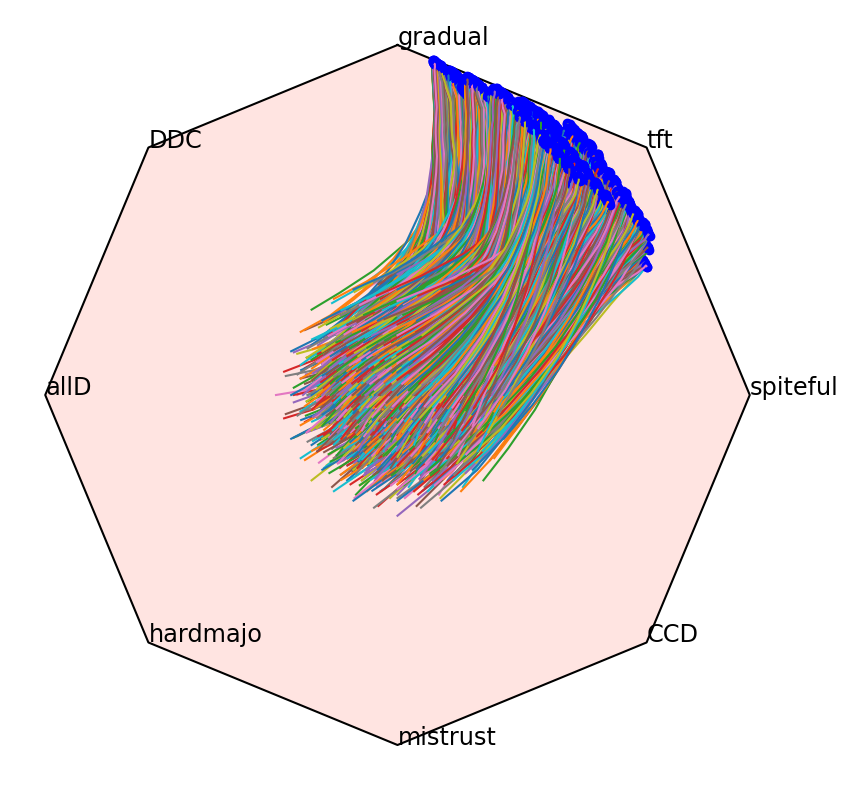

In [17]:
# Par le produit cartésien de [10,200,1000] pour chaque strategies ... si 6 stratégies -> 3^6 trajectoires (au moins 3mn)
# ICI LA FIGURE DEPOSEE COMME BEST FIGURE au concours CNRS de la meilleure image scientifique ... AVEC 1 POINT FIXE
bag=bag6
starts=[10,200,1000]
pops=list( map(list, it.product(starts, repeat=6)))    
print(len(pops),' trajectoires')
#draw_polygon(bag, 'DeterInt', 'com', pops, 'bag8_prod'+str(starts))

# ICI C'EST LA GROSSE BALAYETTE .... AVEC TOUS LES POINTS FIXES DANS LE TRIANGLE (Attention : 8mn !)
bag=bag8
starts=[25,50,75]
pops=list( map(list, it.product(starts, repeat=8)))    
print(len(pops),' trajectoires')
draw_polygon(bag, 'DeterInt', 'ind', pops, 'bag8_prod'+str(starts))


#bag = [Periodic('D','allD'), Periodic('DDC','DDC'), Periodic('CCD','CCD'),   HardMajority(), Mistrust(),Tft(),Gradual(),Spiteful()]
#starts=[100,1000]
#pops=list( map(list, it.product(starts, repeat=8)))
#print(len(pops),' trajectoires')
#draw_polygon(bag, 'DeterInt', 'com', pops, 'bag8_prod'+str(starts))

56  trajectoires
[263468 166532      0      0      0      0      0      0] 	->  gradual
[107673      0 322327      0      0      0      0      0] 	->  spiteful
[430000      0      0      0      0      0      0      0] 	->  gradual
[430000      0      0      0      0      0      0      0] 	->  gradual
[427180      0      0      0      0   2820      0      0] 	->  gradual
[420750   9250      0      0      0      0      0      0] 	->  gradual
[430000      0      0      0      0      0      0      0] 	->  gradual
[     0 303168 126832      0      0      0      0      0] 	->  tft
[     0 392048  37952      0      0      0      0      0] 	->  tft
[     0 430000      0      0      0      0      0      0] 	->  tft
[ 18378 389389  22233      0      0      0      0      0] 	->  tft
[  1798 414436  13766      0      0      0      0      0] 	->  tft
[ 34667 394854    479      0      0      0      0      0] 	->  tft
[     0      0 430000      0      0      0      0      0] 	->  spiteful
[ 85733  17

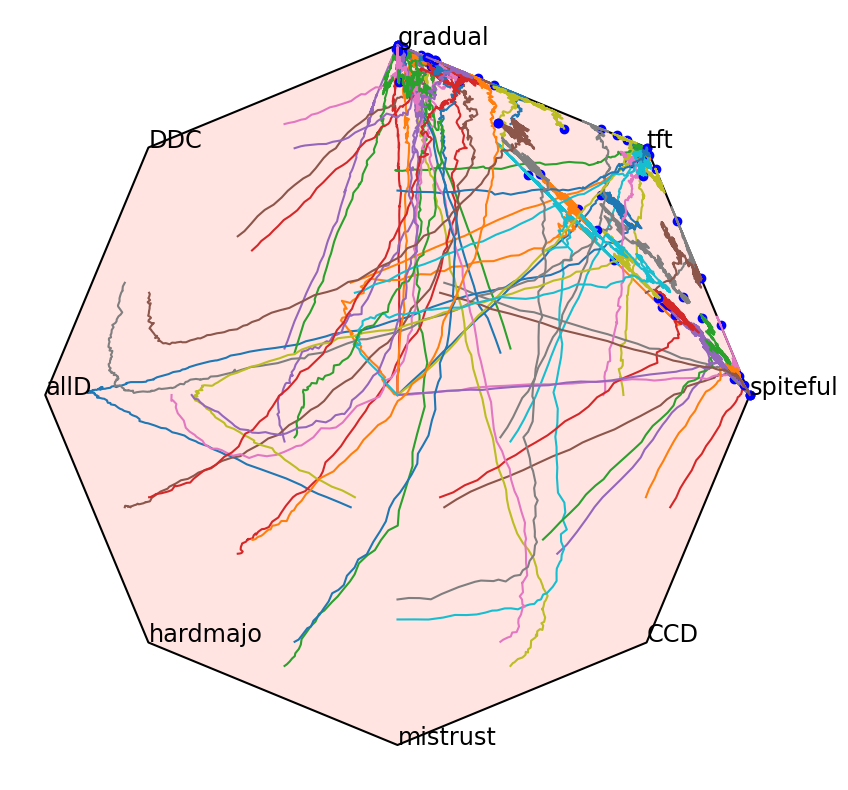

[142223 148148 139629      0      0      0      0      0] 	->  tft
[146636 144351 139013      0      0      0      0      0] 	->  gradual
[145315 143969 140716      0      0      0      0      0] 	->  gradual
[161327 129826      0      0 138847      0      0      0] 	->  gradual
[158856 136440      0      0      0 134704      0      0] 	->  gradual
[146266 151404 132330      0      0      0      0      0] 	->  tft
[142386 139182 148432      0      0      0      0      0] 	->  spiteful
[155415 143033 131552      0      0      0      0      0] 	->  gradual
[144527 137134 148339      0      0      0      0      0] 	->  spiteful
[142296 138407 149297      0      0      0      0      0] 	->  spiteful
[147970 135766 146264      0      0      0      0      0] 	->  gradual
[146569 144945 138486      0      0      0      0      0] 	->  gradual
[149133 137039 143828      0      0      0      0      0] 	->  gradual
[139254 147019 143727      0      0      0      0      0] 	->  tft
[151721 128473 

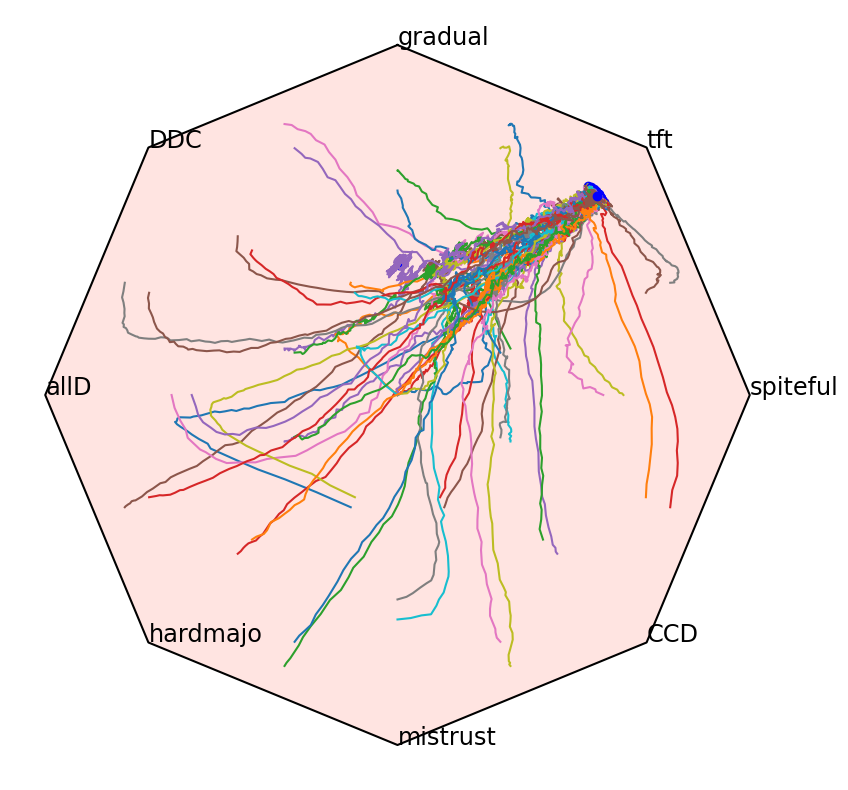

In [18]:
# 2vsTous (Au moins 15mn)
bag = [Periodic('D','allD'), Periodic('DDC','DDC'), Periodic('CCD','CCD'), HardMajority(), Mistrust(),Tft(),Gradual(),Spiteful()]
pops=[] 
starts= [5000,10000]
for n in starts : 
    for i in range(len(bag)) :
        for j in range(i+1,len(bag)) :
            p=[n]*len(bag)
            p[i]=200000
            p[j]=200000
            pops.append(p)
print(len(pops),' trajectoires')
#draw_polygon(bag, 'DeterInt', 'ind', pops, 'polygon_bag8_2[1000]vsTous'+str(starts))
draw_polygon(bag, 'Encounter', 'ind', pops, 'bag8_Enc_ind_2[200000]vsTous'+str(starts))
draw_polygon(bag, 'Encounter', 'com', pops, 'bag8_Enc_com_2[200000]vsTous'+str(starts))


## Plots an Tables of JFSMA 2024 paper and Evolutionary Computation paper (ECJ)

Table 1 : classique individualiste
          prober  gradual  tft  mistrust  allC  allD  Total
prober       104      299  299       295   496    98   1591
gradual      299      300  300       296   300    89   1584
tft          299      300  300       250   300    99   1548
mistrust     300      301  250       100   302   100   1353
allC           6      300  300       297   300     0   1203
allD         108      144  104       100   500   100   1056

Table 2: classique communautariste (diag=0)
          prober  gradual  tft  mistrust  allC  allD  Total
prober         0      299  299       295   496    98   1487
gradual      299        0  300       296   300    89   1284
tft          299      300    0       250   300    99   1248
mistrust     300      301  250         0   302   100   1253
allC           6      300  300       297     0     0    903
allD         108      144  104       100   500     0    956

Table 3: Victoires
          allD  mistrust  prober  tft  gradual  allC  Total


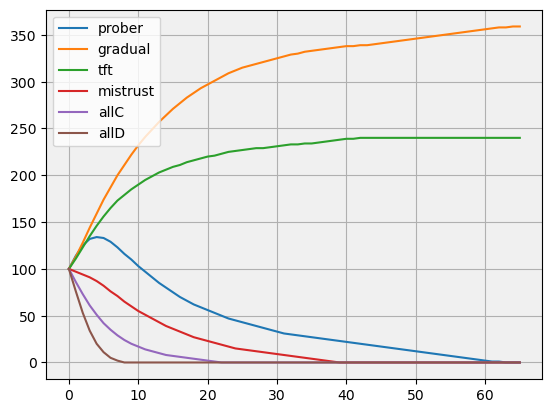

          Det_ind  rank_Det_ind
gradual       359         1.000
tft           240         2.000
prober          0         4.500
mistrust        0         4.500
allC            0         4.500
allD            0         4.500

Fig 2: barycentrique Det(int)
prober       0.000
gradual    839.000
tft        660.000
mistrust     0.000
allC         0.000
allD         0.000
abs          0.866
ord          0.060
Name: 94, dtype: float64
figure sauvée : fig2_bag6_polygon_det_ind_[30,50,100]


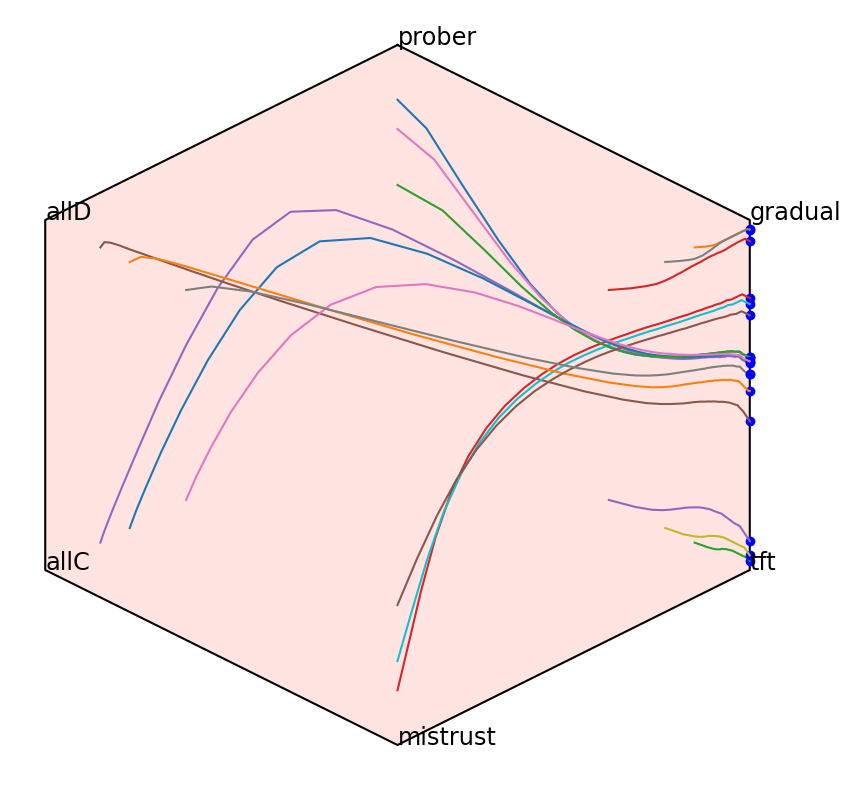


Fig 3: ecologique communautariste (diag=0)
figure sauvée : fig3_bag6_det_com


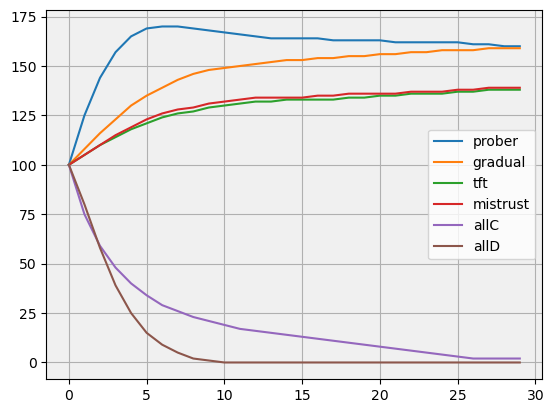

          Det_com  rank_Det_com
prober        160         1.000
gradual       159         2.000
mistrust      139         3.000
tft           138         4.000
allC            2         5.000
allD            0         6.000

Fig 4: barycentrique Det(com)
prober     401.000
gradual    398.000
tft        344.000
mistrust   347.000
allC         7.000
allD         0.000
abs          0.425
ord          0.052
Name: 37, dtype: float64
figure sauvée : fig4_bag6_polygon_det_com_[30,50,100]


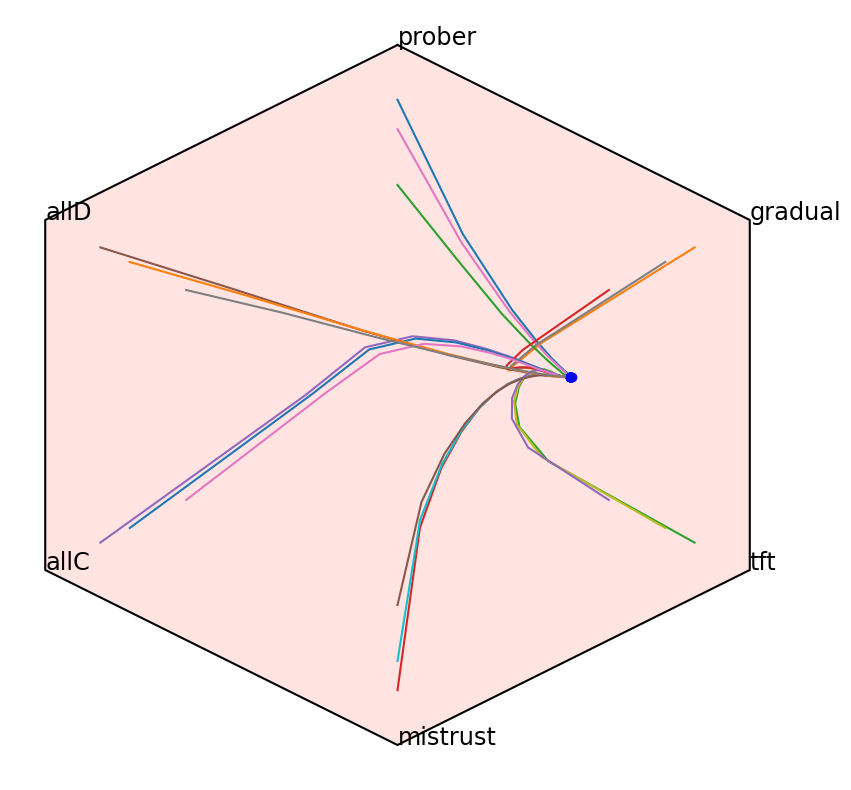


result normalise des 5 methodes deterministes avec tous les bags
deter
-------------  0  -----------------
D
-- result normé : --
           VicT  ClaT_ind  ClaT_com  Det_ind  Det_com
per_ccd  0.200     0.246     0.243    0.468    0.359
per_ddc  0.200     0.149     0.143    0.303    0.052
prober   0.160     0.197     0.212    0.096    0.261
softmajo 0.200     0.226     0.206    0.133    0.185
hardmajo 0.240     0.183     0.196    0.000    0.143
-- dist result :--
           VicT ClaT_ind ClaT_com Det_ind Det_com
VicT     0.000    0.100    0.099   0.385   0.259
ClaT_ind 0.100    0.000    0.030   0.354   0.173
ClaT_com 0.099    0.030    0.000   0.366   0.166
Det_ind  0.385    0.354    0.366   0.000   0.353
Det_com  0.259    0.173    0.166   0.353   0.000
-- rank : --
           rank_VicT  rank_ClaT_ind  rank_ClaT_com  rank_Det_ind  rank_Det_com
per_ccd       3.000          1.000          1.000         1.000         1.000
per_ddc       3.000          5.000          5.000         2.000   

/var/folders/8l/471vznc93g38vw6qr2svj6f80000gn/T/ipykernel_21097/3083014137.py:70: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z = linkage(dist,method='average',metric='euclidean')


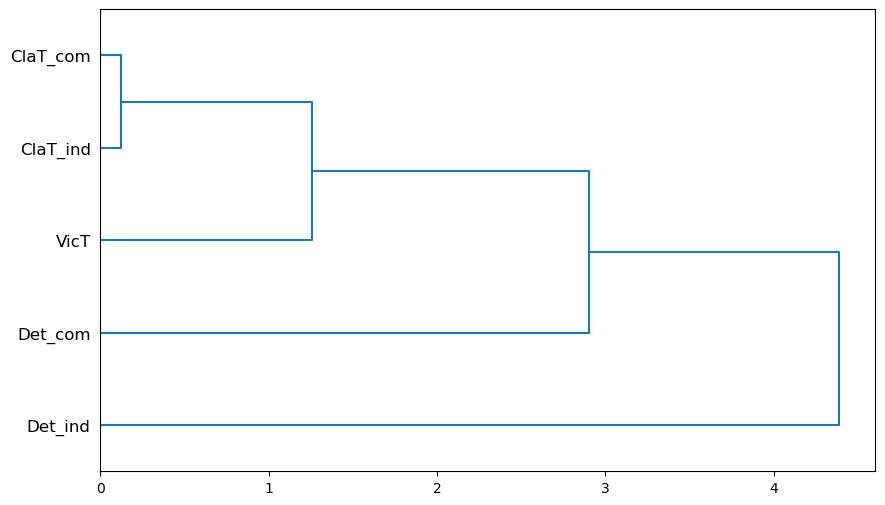

Fig 6 : courbe bag6 Encounter Ind
[ 15636 671898 512466      0      0      0] 	->  gradual
figure sauvée : fig6_bag6_enc_ind


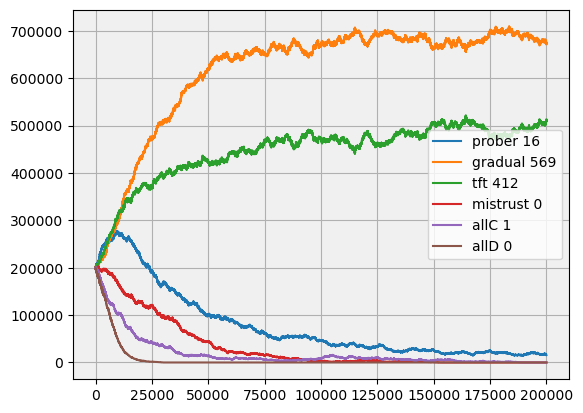

          Enc_ind  rank_Enc_ind
gradual    682911         1.000
tft        495351         2.000
prober      19544         3.000
allC         2165         4.000
mistrust       26         5.000
allD            0         6.000

Fig 7: barycentrique Encounter(ind)
[     0 179126  35874      0      0      0] 	->  gradual
[     0 166729      0      0  48271      0] 	->  gradual
[     0      0 215000      0      0      0] 	->  tft
[     0 215000      0      0      0      0] 	->  gradual
[     0      0 215000      0      0      0] 	->  tft
[     0  51902 163098      0      0      0] 	->  tft
[     0 174877  50123      0      0      0] 	->  gradual
[     0 225000      0      0      0      0] 	->  gradual
[     0      0 225000      0      0      0] 	->  tft
[     0 221134   3866      0      0      0] 	->  gradual
[     0 212065  12935      0      0      0] 	->  gradual
[     0  94645 130355      0      0      0] 	->  tft
[     0 179139  70861      0      0      0] 	->  gradual
[     0 250000    

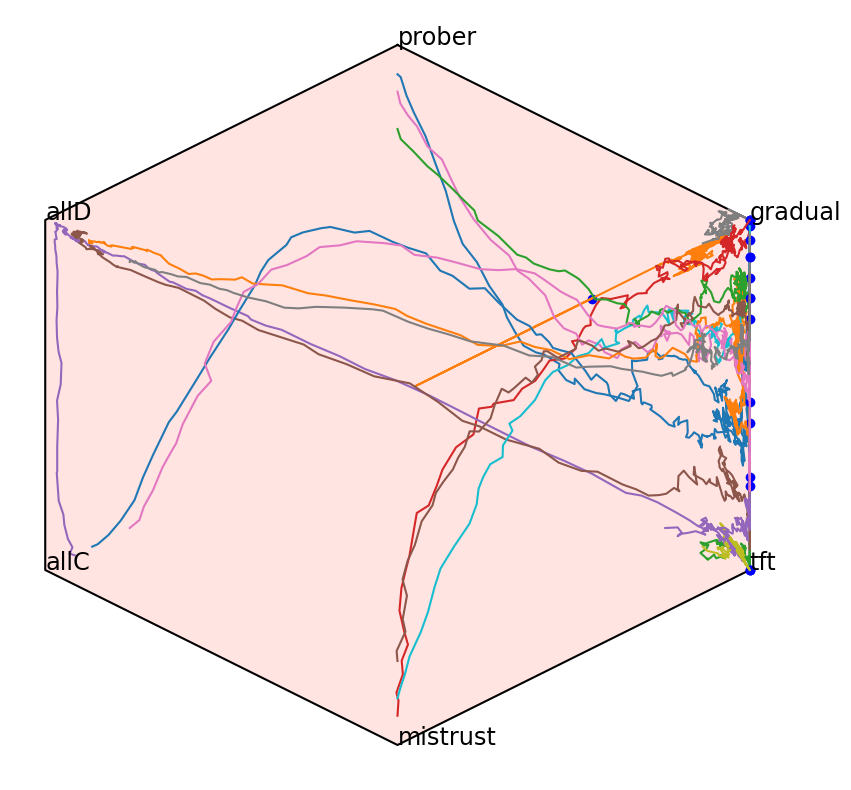


Fig 8 : courbe bag6 Encounter Com
[330491 334833 258234 276442      0      0] 	->  gradual
figure sauvée : fig8_bag6_enc_com


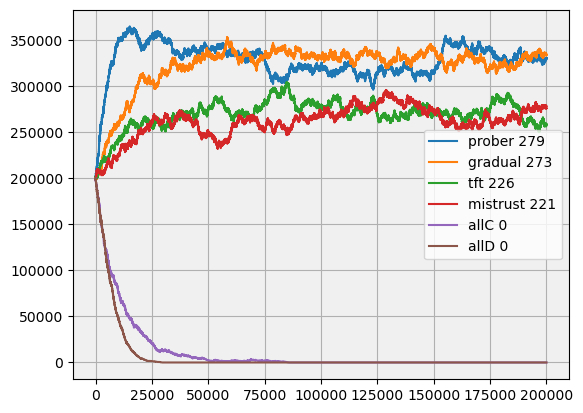

          Enc_com  rank_Enc_com
prober     335650         1.000
gradual    327759         2.000
tft        271347         3.000
mistrust   265243         4.000
allC            0         5.500
allD            0         5.500

Fig 9: barycentrique Encounter(com)
[60802 59227 49412 45559     0     0] 	->  prober
[61226 56529 46717 50528     0     0] 	->  prober
[54980 61655 52941 45424     0     0] 	->  gradual
[67382 62131 47447 38040     0     0] 	->  prober
[62086 59903 48216 44795     0     0] 	->  prober
[58275 56209 46698 53818     0     0] 	->  prober
[60520 59562 50212 54706     0     0] 	->  prober
[59282 65806 53454 46458     0     0] 	->  gradual
[56190 60171 51657 56982     0     0] 	->  gradual
[65148 58639 53448 47765     0     0] 	->  prober
[62514 59509 43978 58999     0     0] 	->  prober
[58823 64561 54017 47599     0     0] 	->  gradual
[68701 74293 66841 40165     0     0] 	->  gradual
[70713 66289 59035 53963     0     0] 	->  prober
[67886 73321 49808 58985     0    

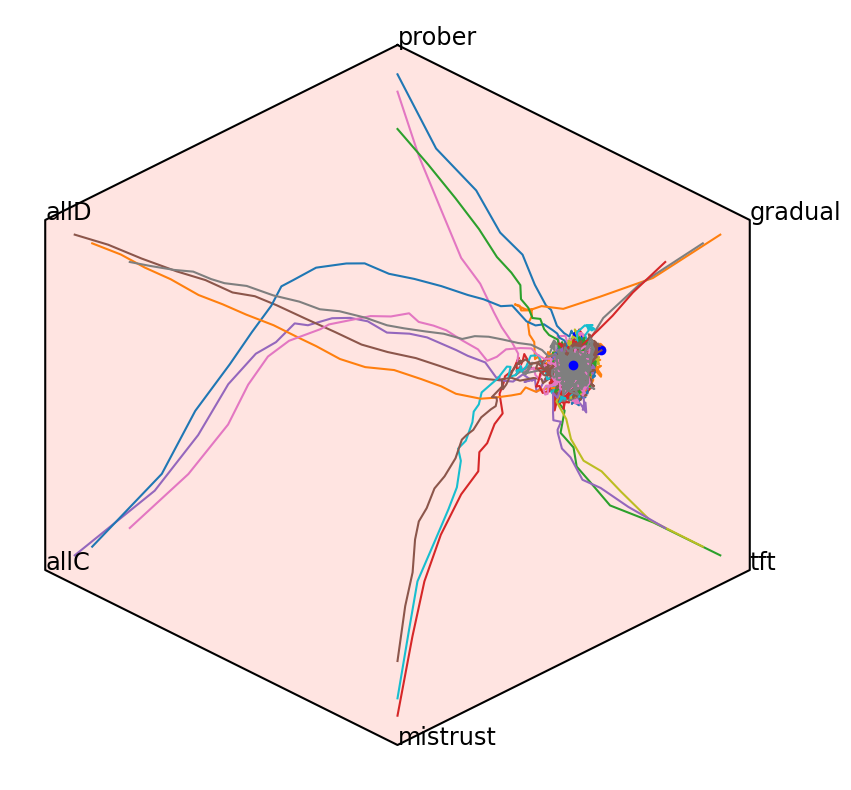


Fig 10 : courbe bag6 Moran ind
[ 221 2853 2856   41   29    0] 	->  tft
figure sauvée : fig10_bag6_mor_ind


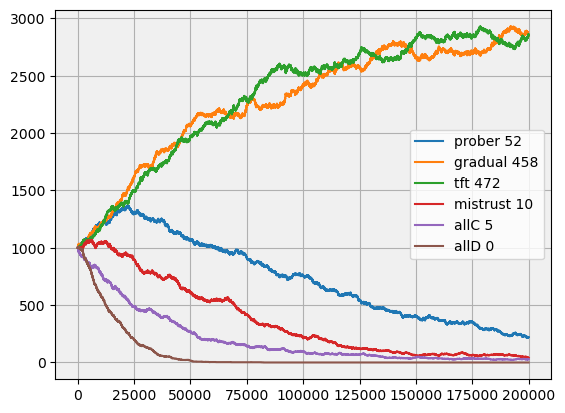

          Mor_ind  rank_Mor_ind
tft          2832         1.000
gradual      2752         2.000
prober        316         3.000
mistrust       65         4.000
allC           32         5.000
allD            0         6.000

Fig 11: barycentrique Moran(ind)
[ 32 854 264   0   0   0] 	->  gradual
[  0 952 198   0   0   0] 	->  gradual
[   0    0 1150    0    0    0] 	->  tft
[  12 1089   31   18    0    0] 	->  gradual
[ 77 565 508   0   0   0] 	->  gradual
[  0 315 835   0   0   0] 	->  tft
[  0 764 486   0   0   0] 	->  gradual
[  0 923 327   0   0   0] 	->  gradual
[   0  195 1011    0   44    0] 	->  tft
[  5 517 728   0   0   0] 	->  tft
[  57 1174   19    0    0    0] 	->  gradual
[ 17 651 582   0   0   0] 	->  gradual
[   0 1140  340   20    0    0] 	->  gradual
[  21 1391    0   88    0    0] 	->  gradual
[  74   48 1336    0   42    0] 	->  tft
[  43 1327  109   21    0    0] 	->  gradual
[ 10 847 643   0   0   0] 	->  gradual
[  24 1093  383    0    0    0] 	->  gradual
prober

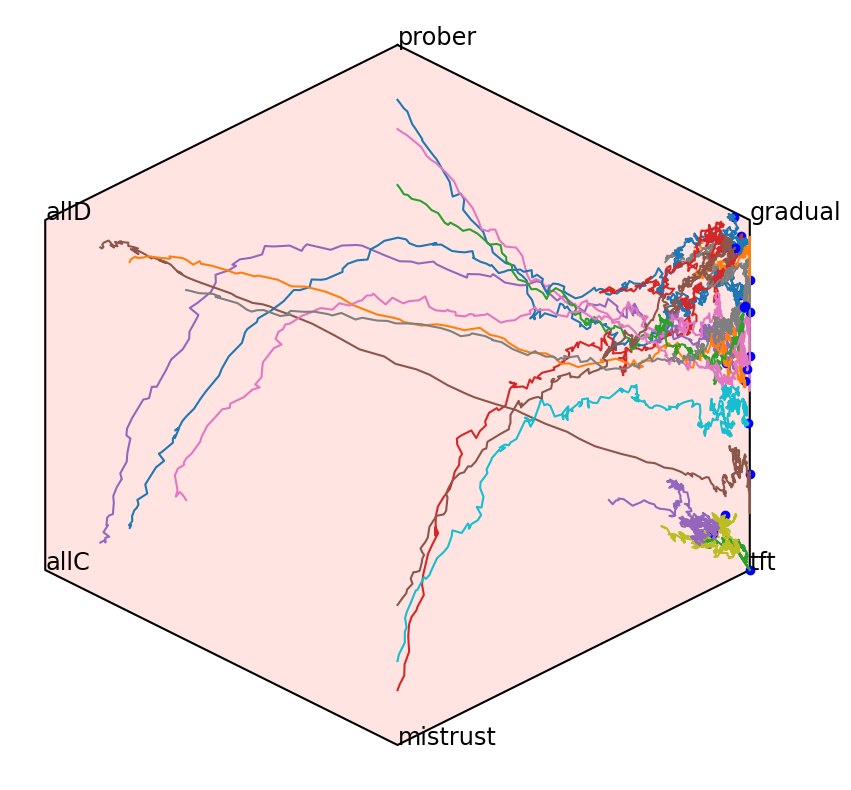


Fig 12 : courbe bag6 Moran com
[1630 1498 1337 1396  139    0] 	->  prober
figure sauvée : fig12_bag6_mor_com


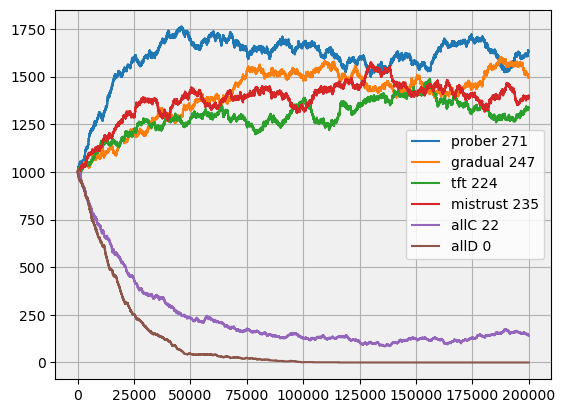

          Mor_com  rank_Mor_com
prober       1626         1.000
gradual      1483         2.000
mistrust     1410         3.000
tft          1346         4.000
allC          133         5.000
allD            0         6.000

Fig 13: barycentrique Moran(com)
[288 296 301 265   0   0] 	->  tft
[267 327 284 272   0   0] 	->  gradual
[300 291 267 292   0   0] 	->  prober
[318 329 238 265   0   0] 	->  gradual
[299 319 259 273   0   0] 	->  gradual
[306 300 267 277   0   0] 	->  prober
[327 366 316 241   0   0] 	->  gradual
[395 318 265 272   0   0] 	->  prober
[363 370 243 274   0   0] 	->  gradual
[345 319 298 288   0   0] 	->  prober
[329 308 271 342   0   0] 	->  mistrust
[343 345 254 308   0   0] 	->  gradual
[432 340 373 355   0   0] 	->  prober
[415 356 380 349   0   0] 	->  prober
[450 397 323 309  21   0] 	->  prober
[389 385 411 315   0   0] 	->  tft
[430 366 346 323  35   0] 	->  prober
[387 435 304 374   0   0] 	->  gradual
prober     387.000
gradual    435.000
tft        304.00

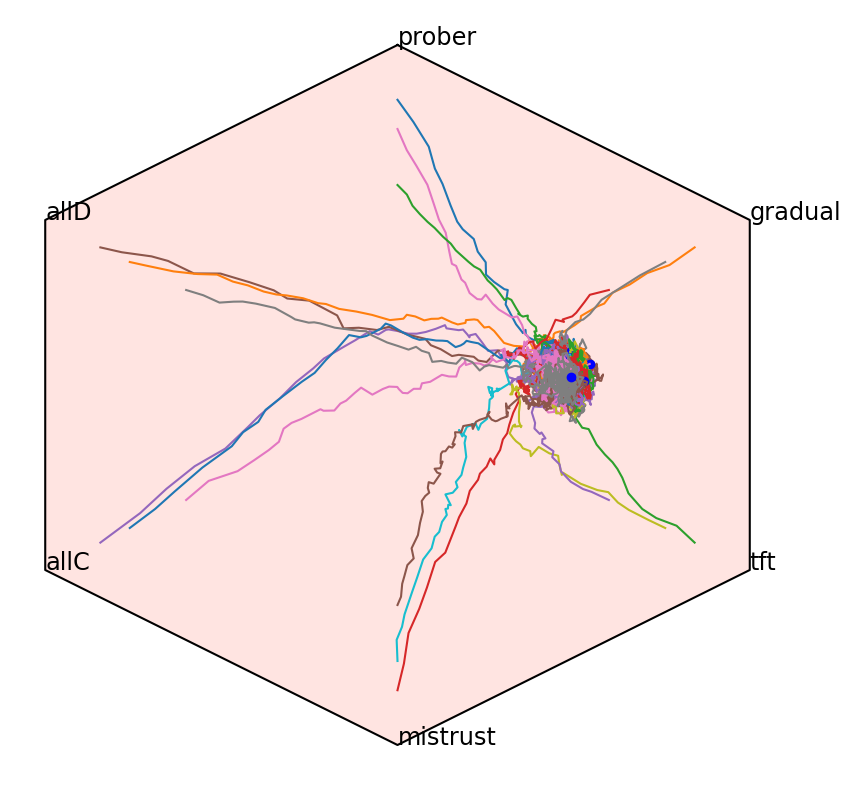


Fig 14 : courbe bag6 Fermi ind
[  2954 596933 600113      0      0      0] 	->  tft
figure sauvée : fig14_bag6_fer_ind


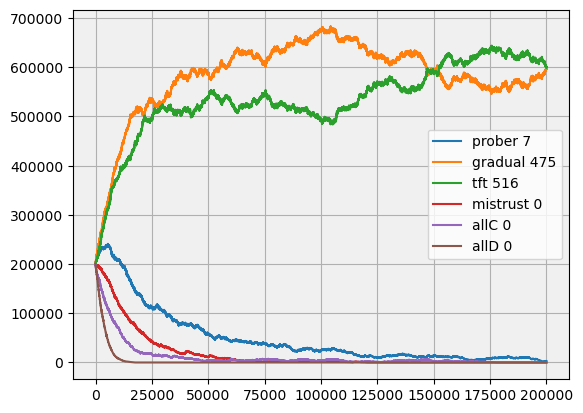

          Fer_ind  rank_Fer_ind
tft        619768         1.000
gradual    570392         2.000
prober       8642         3.000
allC         1196         4.000
mistrust        0         5.500
allD            0         5.500

Fig 15: barycentrique Fermi(ind)
[     0 115627  99373      0      0      0] 	->  gradual
[     0 215000      0      0      0      0] 	->  gradual
[     0      0 215000      0      0      0] 	->  tft
[     0 204019  10981      0      0      0] 	->  gradual
[     0 116352  98648      0      0      0] 	->  gradual
[     0      0 215000      0      0      0] 	->  tft
[     0  40547 184453      0      0      0] 	->  tft
[     0 225000      0      0      0      0] 	->  gradual
[     0      0 225000      0      0      0] 	->  tft
[     0 225000      0      0      0      0] 	->  gradual
[     0  90472 134528      0      0      0] 	->  tft
[     0  30544 194456      0      0      0] 	->  tft
[     0 242923   7077      0      0      0] 	->  gradual
[     0 250000      0    

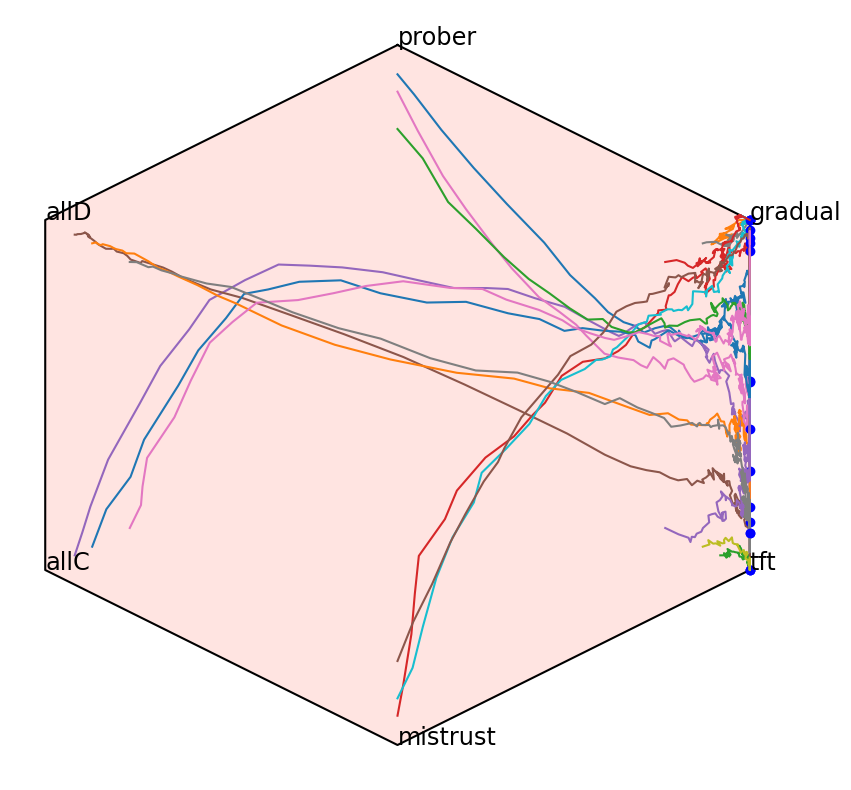


Fig 16 : courbe bag6 Fermi com
[325804 322208 261798 290190      0      0] 	->  prober
figure sauvée : fig16_bag6_fer_com


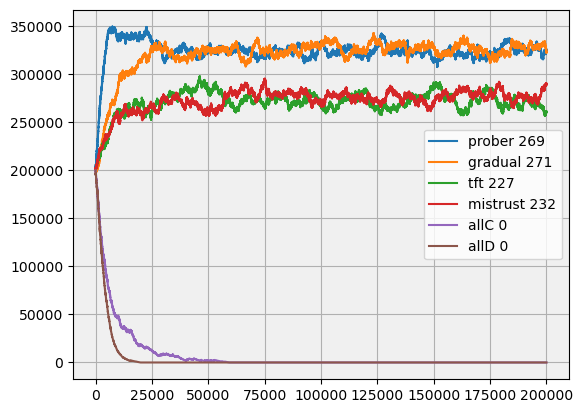

          Fer_com  rank_Fer_com
gradual    325871         1.000
prober     323161         2.000
mistrust   278477         3.000
tft        272490         4.000
allC            0         5.500
allD            0         5.500

Fig 17: barycentrique Fermi(com)
[60848 55739 46993 51420     0     0] 	->  prober
[58323 60863 40299 55515     0     0] 	->  gradual
[57570 58297 47302 51831     0     0] 	->  gradual
[55676 60006 50769 48549     0     0] 	->  gradual
[60711 59767 45925 48597     0     0] 	->  prober
[60199 57771 55296 41734     0     0] 	->  prober
[60125 59565 49875 55435     0     0] 	->  prober
[62323 57935 50707 54035     0     0] 	->  prober
[58563 62785 49787 53865     0     0] 	->  gradual
[57401 64978 46696 55925     0     0] 	->  gradual
[60525 62631 52555 49289     0     0] 	->  gradual
[62860 65065 44733 52342     0     0] 	->  gradual
[68762 64879 61912 54447     0     0] 	->  prober
[65828 67573 60609 55990     0     0] 	->  gradual
[68767 67496 57207 56530     0    

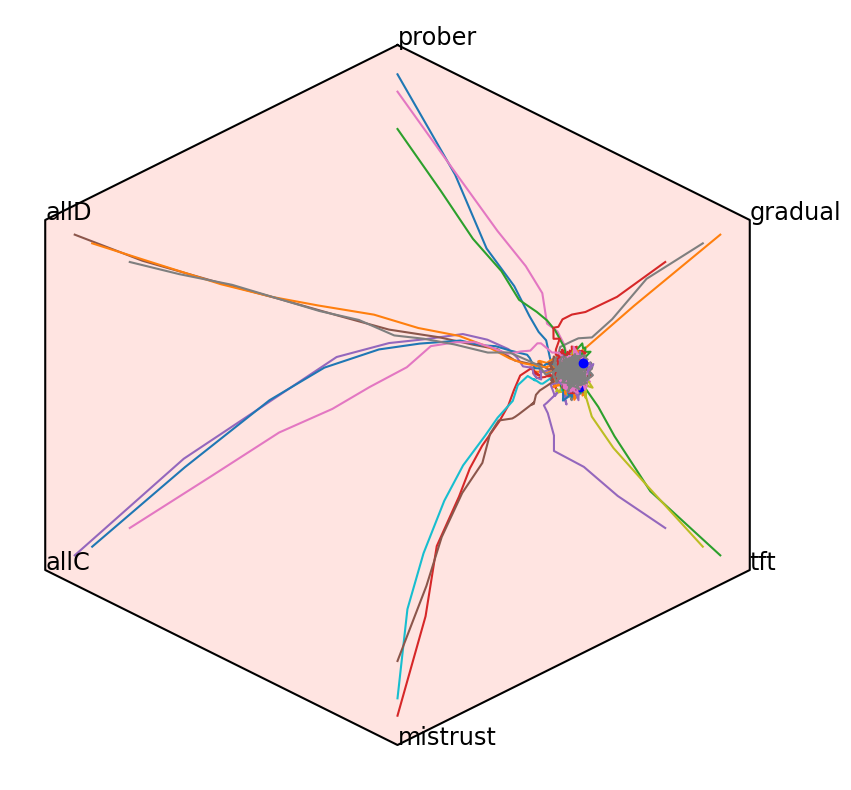


Fig 18: corresponding dendogram
          VicT ClaT_ind ClaT_com Det_ind Det_com Enc_ind Enc_com Fer_ind  \
VicT     0.000    0.682    0.655   2.826   1.912   2.831   1.903   2.914   
ClaT_ind 0.682    0.000    0.080   2.458   1.452   2.474   1.443   2.567   
ClaT_com 0.655    0.080    0.000   2.496   1.438   2.508   1.432   2.601   
Det_ind  2.826    2.458    2.496   0.000   1.920   0.476   1.824   0.532   
Det_com  1.912    1.452    1.438   1.920   0.000   1.985   0.334   2.068   
Enc_ind  2.831    2.474    2.508   0.476   1.985   0.000   1.882   0.325   
Enc_com  1.903    1.443    1.432   1.824   0.334   1.882   0.000   1.967   
Fer_ind  2.914    2.567    2.601   0.532   2.068   0.325   1.967   0.000   
Fer_com  1.767    1.311    1.298   1.934   0.368   1.984   0.297   2.080   
Mor_ind  2.472    2.096    2.133   0.535   1.670   0.740   1.547   0.830   
Mor_com  1.593    1.128    1.114   1.938   0.441   1.978   0.429   2.080   

         Fer_com Mor_ind Mor_com  
VicT       1.767   

/var/folders/8l/471vznc93g38vw6qr2svj6f80000gn/T/ipykernel_21097/3083014137.py:215: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z = linkage(dist,method='average',metric='euclidean')


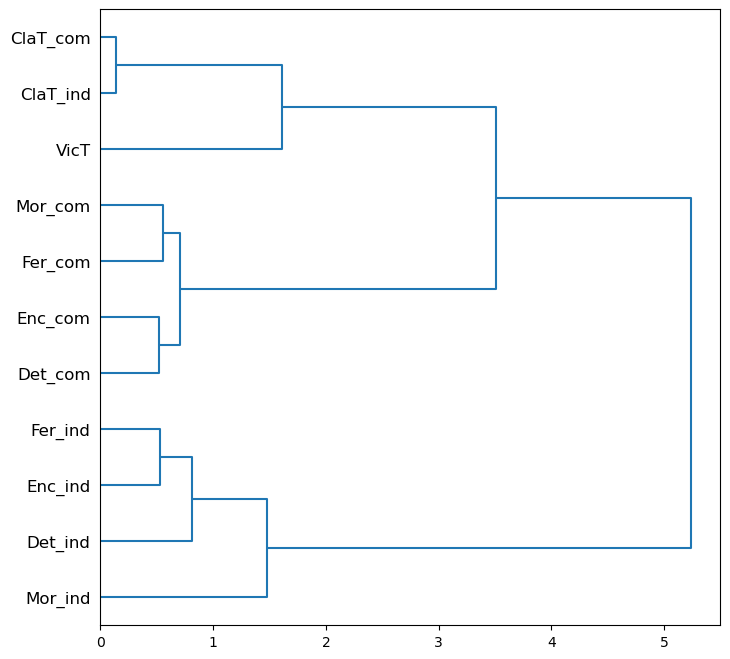

In [19]:
print("Table 1 : classique individualiste")
bag=bag6
t=Tournament(g,bag,100)
t.run()
print(t.matrix)
print()

print("Table 2: classique communautariste (diag=0)")
c=Classic('com',t)
c.run()
print(c.matrix)
print()

print("Table 3: Victoires")
v=TournamentVictory(t)
v.run()
print(v.matrix)
print()

print("Fig 1: ecologique indiv")
m2i=EvolDeterInt('ind', t , 100 , 1000)
m2i.run()
m2i.drawPlot('fig1_bag6_det_ind')
print(m2i.getRanking().sort_values(by='Det_ind', ascending=False))
print()

print("Fig 2: barycentrique Det(int)")
# Toutes à [30,50,100] sauf une à 1000
pops=[]    
for n in [30,50,100] :
    for i in range(len(bag)) :
        p1=[n]*len(bag)
        p1[i]=1000
        pops.append(p1)
draw_polygon(bag, 'DeterInt', 'ind', pops, 'fig2_bag6_polygon_det_ind_[30,50,100]')
print()


print("Fig 3: ecologique communautariste (diag=0)")
m2c=EvolDeterInt('com', t , 100 , 1000)
m2c.run()
m2c.drawPlot('fig3_bag6_det_com')
print(m2c.getRanking().sort_values(by='Det_com', ascending=False))
print()


print("Fig 4: barycentrique Det(com)")
# Toutes à [30,50,100] sauf une à 1000
pops=[]    
for n in [30,50,100] :
    for i in range(len(bag)) :
        p1=[n]*len(bag)
        p1[i]=1000
        pops.append(p1)
draw_polygon(bag, 'DeterInt', 'com', pops, 'fig4_bag6_polygon_det_com_[30,50,100]')
print()

#=================== SUMMARY OF THE DETERMINIST METHODS  ===================================

print("result normalise des 5 methodes deterministes avec tous les bags")
#res,rank = resultMatrix(bag,methods="deter") # deter ou all (all est TRES LONG !!)
dist,rank = cumulativeDistanceMatrix([bag5, bag6, bag11, bag20, bag20+bagDyson, getMem11()],repeat=5,methods="deter") # deter ou all (all est TRES LONG !!)
print(res.sort_values(by="VicT"))
print()
print("Table 4 : distance des 5 methodes deterministes avec tous les bags")
print(dist)
print()

print("Fig 5 : dendogramme correspondant, tous les bags")
Z = linkage(dist,method='average',metric='euclidean')
plt.figure(figsize=(10,6))
dendrogram(Z,labels=dist.index,orientation='right',color_threshold=0)
plt.savefig("fig5_dendo_deter_all6Bags.png", dpi=500)
plt.show()

#===========================================================================================
#==================== INTRODUCTION OF SCOCHASTIC METHODS  ==================================


#--------------- Encounter ---------------------

bag=bag6

print("Fig 6 : courbe bag6 Encounter Ind")  # 2mn30
m3=EvolEncounter('ind', t , 200000 , 200000)
m3.run()
m3.drawPlot('fig6_bag6_enc_ind')
print(m3.getRanking().sort_values(by='Enc_ind', ascending=False))
print()

print("Fig 7: barycentrique Encounter(ind)") # 2m30 * 18 = 45mn
# 100000 iterations. All resp at [3000,5000,10000] except one at 200000
pops=[]    
for n in [3000,5000,10000] :
    for i in range(len(bag)) :
        p1=[n]*len(bag)
        p1[i]=200000
        pops.append(p1)
draw_polygon(bag, 'Encounter', 'ind', pops, 'fig7_bag6_polygon_enc_ind_[3000, 5000, 10000]')
print()


print("Fig 8 : courbe bag6 Encounter Com") # 2mn30
m3=EvolEncounter('com', t , 200000 , 200000)
m3.run()
m3.drawPlot('fig8_bag6_enc_com')
print(m3.getRanking().sort_values(by='Enc_com', ascending=False))
print()

print("Fig 9: barycentrique Encounter(com)") # 2m30 * 18 = 45mn
# 100000 iterations. All resp at [3000,5000,10000] except one at 200000
pops=[]    
for n in [3000,5000,10000] :
    for i in range(len(bag)) :
        p1=[n]*len(bag)
        p1[i]=200000
        pops.append(p1)
draw_polygon(bag, 'Encounter', 'com', pops, 'fig9_bag6_polygon_enc_com_[3000, 5000, 10000]')
print()


#--------------- Moran ---------------------

bag=bag6

print("Fig 10 : courbe bag6 Moran ind") # 2mn30
m3=EvolMoran('ind', t , 1000 , 200000)
m3.run()
m3.drawPlot('fig10_bag6_mor_ind')
print(m3.getRanking().sort_values(by='Mor_ind', ascending=False))
print()

print("Fig 11: barycentrique Moran(ind)") # 2m30 * 18 = 45mn
# Moran : 100000 iterations. All resp at [30,50,100] except one at 1000
pops=[]    
for n in [30,50,100] :
    for i in range(len(bag)) :
        p1=[n]*len(bag)
        p1[i]=1000
        pops.append(p1)
draw_polygon(bag, 'Moran', 'ind', pops, 'fig11_bag6_polygon_mor_ind_[30, 50, 100]')
print()


print("Fig 12 : courbe bag6 Moran com") # 2mn30
m3=EvolMoran('com', t , 1000 , 200000)
m3.run()
m3.drawPlot('fig12_bag6_mor_com')
print(m3.getRanking().sort_values(by='Mor_com', ascending=False))
print()

print("Fig 13: barycentrique Moran(com)") # 2m30 * 18 = 45mn
# Moran : 100000 iterations. All resp at [30,50,100] except one at 1000
pops=[]    
for n in [30,50,100] :
    for i in range(len(bag)) :
        p1=[n]*len(bag)
        p1[i]=1000
        pops.append(p1)
draw_polygon(bag, 'Moran', 'com', pops, 'fig13_bag6_polygon_mor_com_[30, 50, 100]')
print()


#--------------- Fermi ---------------------

bag=bag6

print("Fig 14 : courbe bag6 Fermi ind") # 2mn30
m3=EvolFermi('ind', t , 200000 , 200000)
m3.run()
m3.drawPlot('fig14_bag6_fer_ind')
print(m3.getRanking().sort_values(by='Fer_ind', ascending=False))
print()

print("Fig 15: barycentrique Fermi(ind)") # 2m30 * 18 = 45mn
# Fermi : 100000 iterations. All resp at [3000,5000,10000] except one at 200000
pops=[]    
for n in [3000,5000,10000] :
    for i in range(len(bag)) :
        p1=[n]*len(bag)
        p1[i]=200000
        pops.append(p1)
draw_polygon(bag, 'Fermi', 'ind', pops, 'fig15_bag6_polygon_fer_ind_[3000, 5000, 10000]')
print()


print("Fig 16 : courbe bag6 Fermi com") # 2mn30
m3=EvolFermi('com', t , 200000 , 200000)
m3.run()
m3.drawPlot('fig16_bag6_fer_com')
print(m3.getRanking().sort_values(by='Fer_com', ascending=False))
print()


print("Fig 17: barycentrique Fermi(com)") # 2m30 * 18 = 45mn
# Fermi : 100000 iterations. All resp at [3000,5000,10000] except one at 200000
pops=[]    
for n in [3000,5000,10000] :
    for i in range(len(bag)) :
        p1=[n]*len(bag)
        p1[i]=200000
        pops.append(p1)
draw_polygon(bag, 'Fermi', 'com', pops, 'fig17_bag6_polygon_fer_com_[3000, 5000, 10000]')
print()



#=================== SUMMARY OF ALL (determinist and probabilist) METHODS  ========================

print("Fig 18: corresponding dendogram") # at least 2h
#dist,rank = cumulativeDistanceMatrix([bag5,bag6,bag11,bag20,bag20+bagDyson,getMem11()],methods="A")
#dist.to_pickle("fig18_dist.pkl")
dist=pd.read_pickle("fig18_dist.pkl")
print(dist)
Z = linkage(dist,method='average',metric='euclidean')
plt.figure(figsize=(8,8))
dendrogram(Z,labels=dist.index,orientation='right',color_threshold=0)
plt.savefig("fig18_dendo_11meth_All6bags.png", dpi=500)
plt.show()


## Plots and Tables of PLS520 paper
[Pour La Science](https://www.pourlascience.fr/), [num 520](https://www.pourlascience.fr/sr/logique-calcul/les-premiers-seront-ils-les-derniers-20780.php), pp 80-85

tft     	C D C D C D C D C D = 25
mistrust	D C D C D C D C D C = 25

prober  	D C C C C C C C C C = 29
gradual 	C D C C C C C C C C = 29

per_D   	D D D D D D D D D D = 30
gradual 	C D C C D D D D C C = 5
--- classement M0 ---
per_ddc     2
mistrust    2
prober     -1
per_ccd    -3
Name: Total, dtype: int64
--- classement M1 ---
per_ccd     927
per_ddc     906
mistrust    868
prober      864
Name: Total, dtype: int64
--- classement M2 ---
   per_ddc  per_ccd  mistrust  prober
0      196       75        65      61
figure sauvée : 4str_DetInt_ind_res0_1711577960143.png


<Figure size 1500x1500 with 0 Axes>

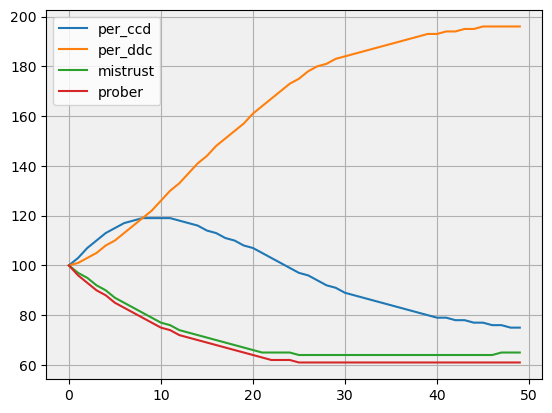

[168612 128419 259611 243358] 	->  mistrust
figure sauvée : 4str_EvolEncounter_com_1711578054389.png


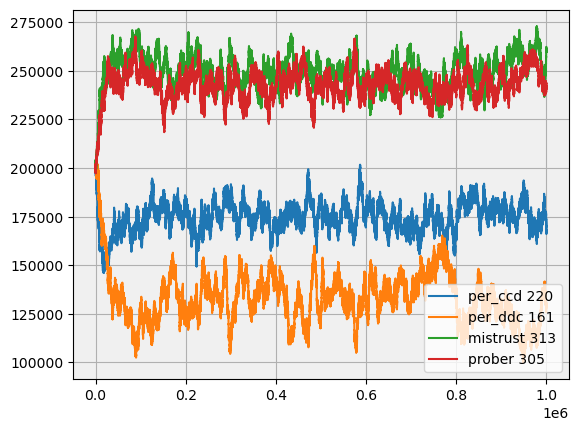

[176406 177195 227025 219374] 	->  mistrust
figure sauvée : 4str_EvolFermi_pls_1711578136147.png


KeyboardInterrupt: 

In [20]:
# ATTENTION : TAKE MORE THAT 5mn  !!!!

plt.figure(figsize=(15,15))
  
# FIGURE 2 : rencontres et matrice
m=Meeting(g,Tft(),Mistrust(),10)
m.run()
m.prettyPrint()
print()

m=Meeting(g,Prober(),Gradual(),10)
m.run()
m.prettyPrint()
print()

m=Meeting(g,Periodic('D','per_D'),Gradual(),10)
m.run()
m.prettyPrint()


bag=bag6
m1=Tournament(g,bag,100)
m1.run()
m1.matrix


# Texte page 82, bas 2è colonne : M0
bag=bag6
m1=Tournament(g,bag,100)
m1.run()
m0 = TournamentVictory(m1)
m0.run()
m0.matrix

# FIGURE 3
bag=bag4
m1=Tournament(g,bag,100)
m1.run()
# classement M0
m0 = TournamentVictory(m1)
m0.run()
print('--- classement M0 ---')
print(m0.matrix['Total'])
# classement M1
print('--- classement M1 ---')
print(m1.matrix['Total'])
# classement M2
print('--- classement M2 ---')
m2=EvolDeterInt('ind',m1, 100 , 1000)
m2.run()
print(pd.DataFrame(m2.historic[-1:], columns=m2.nomstrats).sort_values(axis=1, by=0, ascending=False))
# et les 3 courbes page 82 et 83
m2.drawPlot()
m3=EvolEncounter('com', m1, 200000 , 1000000)
m3.run()
m3.drawPlot()
m5=EvolFermi('pls', m1, 200000 , 1000000)
m5.run()
m5.drawPlot()

# FIGURE flottante p84
bag=bag6
m1=Tournament(g,bag,100)
m1.run()
m2=EvolDeterInt('ind', m1, 100, 1000)
m2.run()
m2.drawPlot()


# Figure 4
bag=[Periodic('C','allC'), Periodic('D','allD'), Tft(), Gradual(), Mistrust(), Prober(), Spiteful(), HardMajority(), SoftMajority(), Periodic('CD','per_CD')]
m1=Tournament(g,bag,100)
m1.run()
# bistable ... selon les exécutions croisement entre rancuniere et Prober  ou pas
# Du coup on en a mis deux .... une de chaque cas
m5=EvolFermi('pls', m1, 200000 , 1000000)
m5.run()
m5.drawPlot()

# FIGURES Flottantes page 85
bag=bag6
m1=Tournament(g,bag,100)
m1.run()
m3=EvolEncounter('com', m1, 200000 , 500000)
m5=EvolFermi('pls', m1, 200000 , 100000)

